In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib
import time
from sklearn.model_selection import cross_val_score,train_test_split, GridSearchCV
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FunctionTransformer, make_pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer

# EXAMEN

## EJERCICIO 1

Carga el conjunto de datos Iris (el de las flores según la anchura y la altura del pétalo y del sépalo) desde scikit-learn (se ha hecho en algún ejercicio).

Explora los datos visualmente utilizando gráficos: representa la distribución de cada variable (todas las de X e y), diagramas de cajas de cada variable (todas las de X) y la matriz de correlaciones para entender las relaciones entre las características. ¿Qué puedes deducir?

Divide el conjunto de datos en entrenamiento y prueba, estratificando por el tipo de flor.

Prepara los datos mediante una pipeline.

Entrena y evalúa un clasificador Random Forest utilizando validación cruzada. ¿Qué métrica has usado para evaluar el modelo y por qué? ¿Cuál es el mejor y el peor error que consigues?

Optimiza el número de árboles, ¿cuál es el mejor valor?

Evalúa el rendimiento del modelo optimizado en el conjunto de prueba.

Guarda el modelo en un fichero y cárgalo desde un fichero .py que pida 4 datos para una nueva flor (anchura del pétalo, longitud del pétalo, anchura del sépalo y longitud del sépalo) y prediga de que clase es la flor (quiero que me de un nombre, no un número y hay que controlar las excepciones).

In [732]:
# Carga de datos
iris = load_iris(as_frame=True)
X, y = iris.data, iris.target

In [733]:
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [734]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [735]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


In [736]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 150 entries, 0 to 149
Series name: target
Non-Null Count  Dtype
--------------  -----
150 non-null    int64
dtypes: int64(1)
memory usage: 1.3 KB


Representa la matriz de correlaciones

In [737]:
datos=pd.concat([X , y], axis=1)
corr_matrix = datos.corr(numeric_only=True)
corr_matrix['target'].sort_values(ascending=False)

target               1.000000
petal width (cm)     0.956547
petal length (cm)    0.949035
sepal length (cm)    0.782561
sepal width (cm)    -0.426658
Name: target, dtype: float64

In [738]:
corr_matrix.style.background_gradient()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
sepal length (cm),1.000000,-0.117570,0.871754,0.817941,0.782561
sepal width (cm),-0.117570,1.000000,-0.428440,-0.366126,-0.426658
petal length (cm),0.871754,-0.428440,1.000000,0.962865,0.949035
petal width (cm),0.817941,-0.366126,0.962865,1.000000,0.956547
target,0.782561,-0.426658,0.949035,0.956547,1.000000


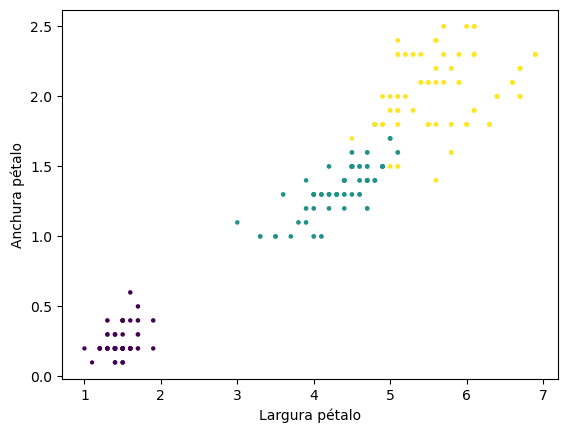

In [739]:
plt.scatter(x = datos["petal length (cm)"],
            y = datos["petal width (cm)"],
            c = datos["target"],
            s = datos["sepal length (cm)"])

plt.xlabel("Largura pétalo")
plt.ylabel("Anchura pétalo")
plt.show()

In [740]:
#Gracias a los datos de las variables y a los gráficos, podemos ver que no hay valores nulos dentro del
# conjunto . Vemos que hay 3 tipos de flores y que los datos mas relacionados con cada flor son la largura 
# y la anchura del petalo. 

In [741]:
# Estratificamos los datos por target
train, test = train_test_split(datos, train_size=0.2, random_state=5, stratify=datos["target"])

In [742]:
# División de X e y
X_train, y_train, X_test, y_test = train.drop("target", axis = 1), train["target"], test.drop("target", axis = 1), test["target"]

In [743]:
modelo = make_pipeline(
    SimpleImputer(strategy="mean"), 
    StandardScaler(), 
    RandomForestClassifier(n_estimators=35,
                           random_state=42)
) 

modelo.fit(X_test, y_test)


Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=35, random_state=42))])

In [744]:
predicciones = cross_val_score(modelo, X_train, y_train, scoring="f1_macro", cv=5)

In [745]:
print(f"F1 con peor error: {predicciones.min()}")
print(f"F1 con mejor error: {predicciones.max()}")

F1 con peor error: 0.8222222222222223
F1 con mejor error: 1.0


In [746]:
#He utilizado la métrica F1 que combina las métricas de precisión y sensibilidad. 
# Por defecto cross_val_score utiliza la  exactitud (accuracy), pero está métrica no es 
# la ideal en algoritmos de clasificación, cuando tiene que acertar como en este caso 3 clases 
# porque hasta cuando no sepa cual es tiene un 33% de probabilidad de acertar.
# Utilizamos f1 ya que esta métrica tiene en cuenta los verdaderos negativos, verdaderos positivos, 
# falsos negativos y falsos positivos.

In [747]:
params = {
    "randomforestclassifier__n_estimators": [3, 5, 10, 50, 100, 150]
}

grid_search = GridSearchCV(modelo, params, scoring="f1_macro", cv = 5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(n_estimators=35,
                                                               random_state=42))]),
             param_grid={'randomforestclassifier__n_estimators': [3, 5, 10, 50,
                                                                  100, 150]},
             scoring='f1_macro')

In [748]:
grid_search.best_params_

{'randomforestclassifier__n_estimators': 3}

In [749]:
#El mejor numero de arboles en nuestro caso es de 3

In [750]:
final_model=grid_search.best_estimator_

In [751]:
final_predictions=final_model.predict(X_test)

#F1 de test
print(f"Test F1: {f1_score(y_test, final_predictions, average='macro')}")

Test F1: 0.9331662489557226


In [752]:
joblib.dump(final_model, "flores.pkl")

['flores.pkl']

## EJERCICIO 2

En este ejercicio, trabajarás con un conjunto de datos de pruebas creados (ejercicio2.csv). 

Tu objetivo es construir un modelo de regresión que pueda predecir con precisión la variable dependiente y a partir de las variables independientes x1 y x2. 

Deberás:
* Cargar los datos
* Visualizar gráficamente los datos (x1 respecto a y e x2 respecto a y)
* Dividir los datos en conjunto de entrenamiento y pruebas
* Probar diferentes modelos de regresión polinómica (PolynomialFeatures + ), hasta ver cuál es el mejor degree (y explicarlo gráficamente y por medida del error en los conjuntos de entrenamiento y pruebas), no hace falta que uses validación cruzada. ¿Qué medición has usado para evaluar el modelo y por qué? ¿cuál es el mejor degree?
* Probar ahora con Elastic Net, optimizando los hiperparámetros con búsqueda exhaustiva, ¿ha mejorado con esta regularización? ¿cuáles son los mejores datos para los hiperparámetros?

Pista para hacer la gráfica:

´´´´´´

    degrees = [1, 2, 3, 4, 5]
    train_errors = []
    test_errors = []

    for degree in degrees:
        model = Pipeline([
            XXX
        ])
        model.fit(XXX)

        y_train_pred = model.predict(XXX)
        y_test_pred = model.predict(XXX)
        train_error= XXX #medir el error en el conjunto de entrenamiento
        test_error= XXX #medir el error en el conjunto de test
        train_errors.append(train_error)
        test_errors.append(test_error)
        print("Grado: {}, error entrenamiento:{} , error test: {}".format(degree, train_error,test_error))

    plt.figure(figsize=(10, 6))
    plt.plot(degrees, train_errors, label='Train Error')
    plt.plot(degrees, test_errors, label='Test Error')
    plt.xlabel('Degree of Polynomial')
    plt.ylabel('Mean Squared Error')
    plt.title('Error vs. Degree of Polynomial')
    plt.legend()
    plt.show()

´´´´´´

In [753]:
# Carga de datos
data2 = pd.read_csv("ejercicio2.csv")
data2

,x1,x2,y
0,0.488135,3.115185,-91.197936
1,2.151894,-0.239160,-44.928270
2,1.027634,0.231560,-5.347793
3,0.448832,-2.494794,78.026649
4,-0.763452,1.050430,2.176875
...,...,...,...
1995,2.912816,-1.503606,-54.720299
1996,2.211981,-0.651264,-39.841896
1997,-0.198922,3.300029,-104.087315
1998,1.438640,4.328062,-303.627063


In [754]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      2000 non-null   float64
 1   x2      2000 non-null   float64
 2   y       2000 non-null   float64
dtypes: float64(3)
memory usage: 47.0 KB


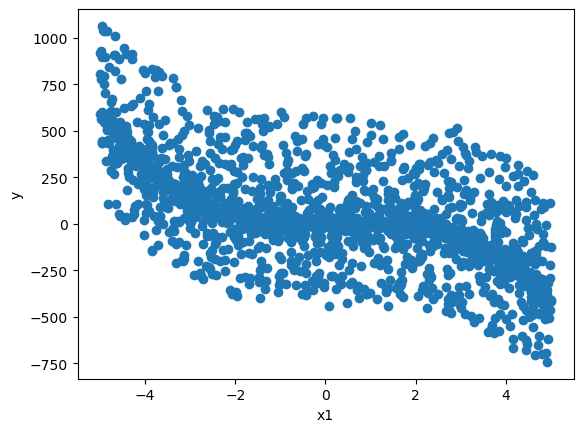

In [755]:
# x1 respecto a y
plt.scatter(x = data2["x1"], y = data2["y"])
plt.xlabel("x1")
plt.ylabel("y")
plt.show()

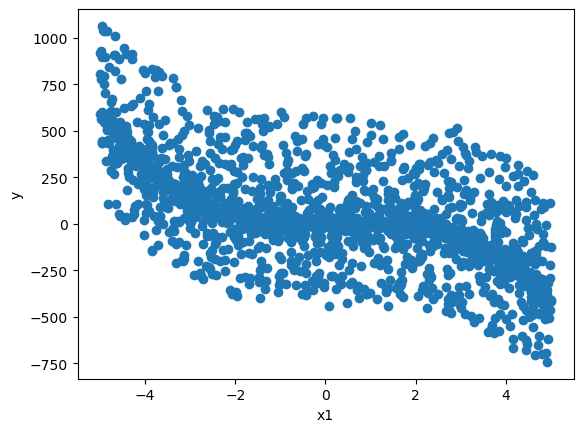

In [756]:
# x2 respecto a y
plt.scatter(x = data2["x1"], y = data2["y"])
plt.xlabel("x1")
plt.ylabel("y")
plt.show()

In [757]:
# Separamos la X y la y
X, y = data2.drop("y", axis = 1), data2["y"]

In [758]:
# Separamos conjunto de entrenamiento y pruebas.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Grado: 1, error entrenamiento:12803.587871969114 , error test: 11861.869412948168
Grado: 2, error entrenamiento:11613.473696892288 , error test: 11529.182454843174
Grado: 3, error entrenamiento:99.80667070971627 , error test: 107.59929884331585
Grado: 4, error entrenamiento:99.6033591497668 , error test: 107.11796410944893
Grado: 5, error entrenamiento:99.47085003938304 , error test: 107.19109264735654


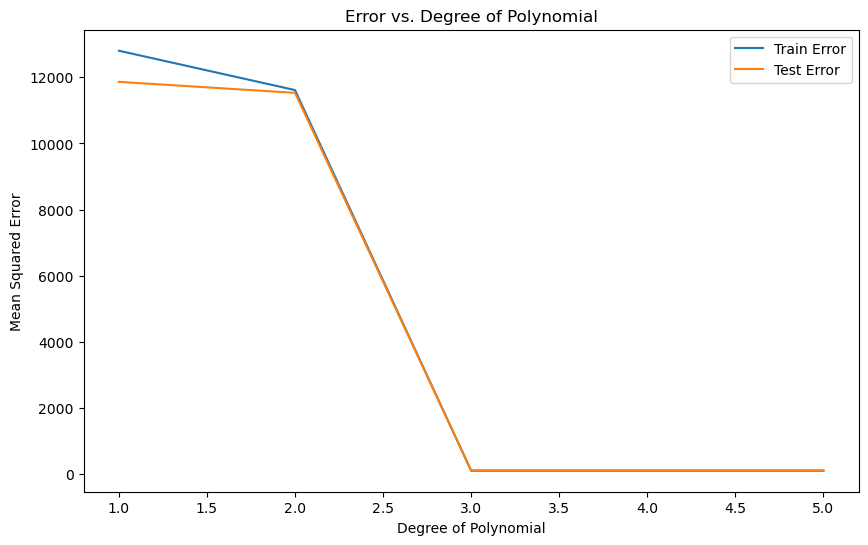

In [759]:
degrees = [1, 2, 3, 4, 5]
train_errors = []
test_errors = []

for degree in degrees:
    model = make_pipeline(
        StandardScaler(),
        PolynomialFeatures(degree=degree),
        LinearRegression())
    model.fit(X_train,y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_error= mean_squared_error(y_train, y_train_pred) #medir el error en el conjunto de entrenamiento
    test_error= mean_squared_error(y_test, y_test_pred) #medir el error en el conjunto de test
    train_errors.append(train_error)
    test_errors.append(test_error)
    print("Grado: {}, error entrenamiento:{} , error test: {}".format(degree, train_error,test_error))

plt.figure(figsize=(10, 6))
plt.plot(degrees, train_errors, label='Train Error')
plt.plot(degrees, test_errors, label='Test Error')
plt.xlabel('Degree of Polynomial')
plt.ylabel('Mean Squared Error')
plt.title('Error vs. Degree of Polynomial')
plt.legend()
plt.show()

In [760]:
# Podemos ver gracias al grafico que los grados 3, 4 ,5 estan muy parejos en cuantos a error. Pero
# es el grado 4 el que saca mejores datos en error de test. Hemos utilizado el Error Cuadrático Medio 
# porque estamos ante un caso de regresion, donde la accuracy no tendria sentido ya que  un error de un 
# por muy pequeño que fuese contaría como error.

In [761]:
params2 = {
    "elasticnet__alpha": [0.0001, 0.001, 0.1, 1, 10], # alpha, coeficiente que multiplica la penalización
    "elasticnet__l1_ratio": [0.01, 0.25, 0.5, 0.75, 0.99] # l1_ratio. 0 Ridge y 1 Lasso. Un valor intermedio ambas.
}

modelo2= make_pipeline(
    StandardScaler(),
    ElasticNet(random_state=42)
)

grid_search2 = GridSearchCV(modelo2, params2, scoring="neg_mean_squared_error")
grid_search2.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('elasticnet',
                                        ElasticNet(random_state=42))]),
             param_grid={'elasticnet__alpha': [0.0001, 0.001, 0.1, 1, 10],
                         'elasticnet__l1_ratio': [0.01, 0.25, 0.5, 0.75, 0.99]},
             scoring='neg_mean_squared_error')

In [762]:
#Mejores hiperparametros
grid_search2.best_params_

{'elasticnet__alpha': 0.0001, 'elasticnet__l1_ratio': 0.01}

In [763]:
print(f"Train : {mean_squared_error(y_train, grid_search2.best_estimator_.predict(X_train))}")
print(f"Test : {mean_squared_error(y_test, grid_search2.best_estimator_.predict(X_test))}")

Train : 12803.58855180457
Test : 11861.120122657747


In [764]:
#Si comparamos los datos del polynomial features y de elasticnet podemos ver que el modelo no a
# mejorado y los nuevos datos se encuentran cerca de los que antes eran los peores.

## EJERCICIO 3

Queremos predecir la calidad del vino (quality) a partir del resto de características.

Carga el conjunto de datos winequality.csv, explora los datos y divide el conjunto de datos en entrenamiento y pruebas (10% para las pruebas).

Crea una pipeline para preparar los datos y aplicar un algoritmo de máquinas de vector soporte, entrena el modelo (guarda el tiempo que tardas en entrenar el modelo) y evalúa el modelo en el conjunto de pruebas (no hace falta que pruebes con diferentes hiperparámetros...)

Crea una pipeline para preparar los datos y aplicar PCA que explique al menos el 95% de la varianza, aplica esta pipeline al conjunto de entrenamiento y al conjunto de pruebas.

Muestra cuantas dimensiones tenías al principio y cuantas después de aplicar PCA.

Aplica a los datos obtenido de aplicar PCA el algoritmo de máquinas de vector soporte, entrena el modelo (guarda el tiempo que tardas en entrenar el modelo) y evalúa el modelo en el conjunto de pruebas (no hace falta que pruebes con diferentes hiperparámetros...)

Compara el error y el tiempo empleado en los dos modelos (sin pca y con pca) e interpreta el resultado.


In [765]:
data_vino = pd.read_csv("winequality.csv", delimiter=";")
data_vino

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [766]:
data_vino.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [767]:
data_vino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [768]:
data_vino_corr = data_vino.corr()
data_vino_corr['quality'].sort_values(ascending=False)

quality                 1.000000
alcohol                 0.476166
sulphates               0.251397
citric acid             0.226373
fixed acidity           0.124052
residual sugar          0.013732
free sulfur dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total sulfur dioxide   -0.185100
volatile acidity       -0.390558
Name: quality, dtype: float64

In [769]:
data_vino_corr.style.background_gradient()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.050656
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.185100
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.174919
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057731
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.251397


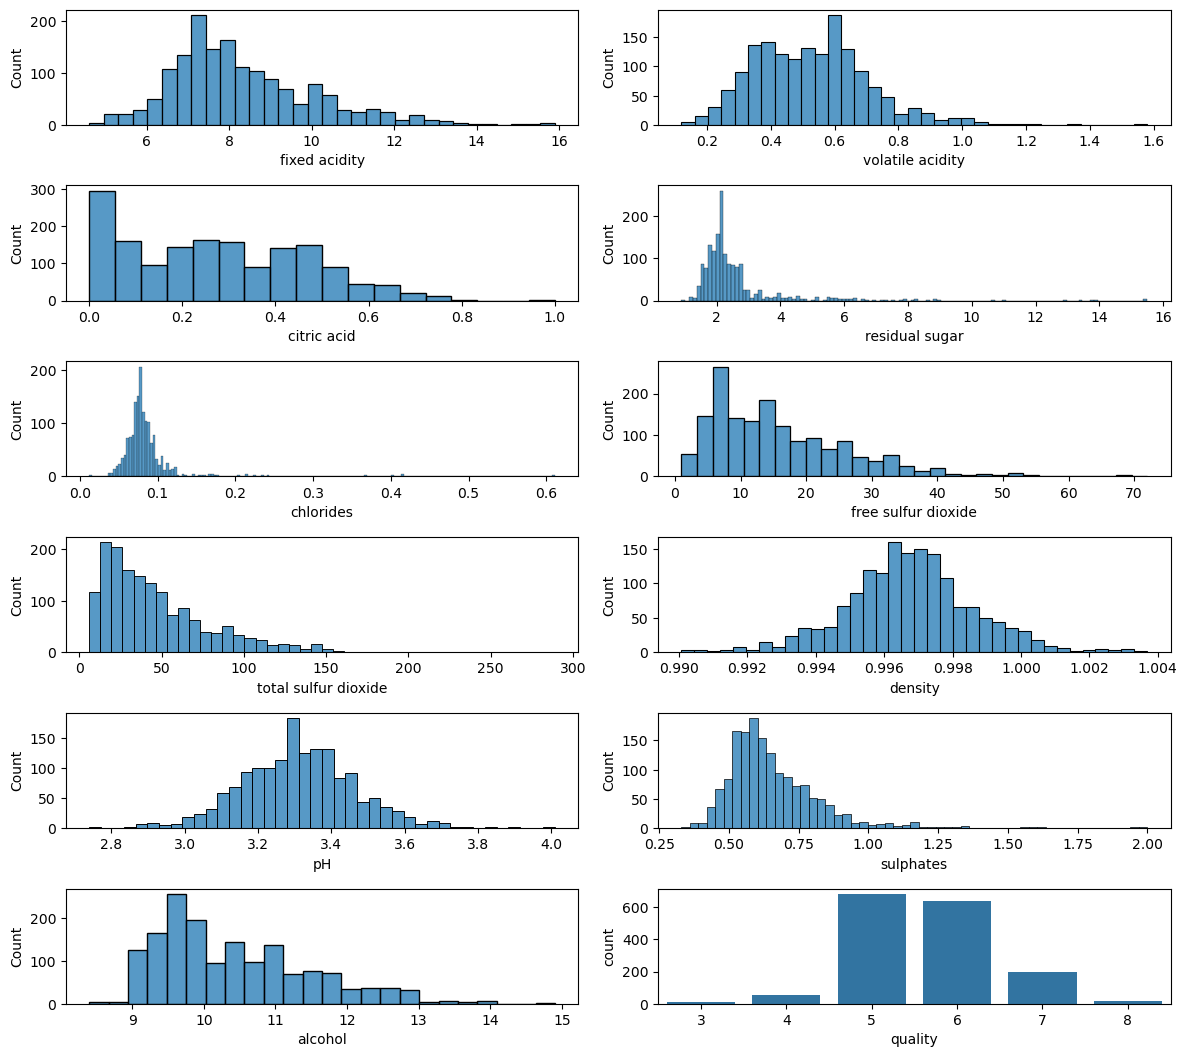

In [770]:
df_object = data_vino.select_dtypes(include=["object","category"]).columns.to_list()
df_num = data_vino.select_dtypes(include=[np.number]).columns.to_list()

df_num.remove("quality")
df_object.extend(["quality"])
plt.figure(figsize=(12,12))

subplot_index=1

for col in df_num:
    plt.subplot(7,2,subplot_index)
    sns.histplot(x=data_vino[col])
    subplot_index+=1

for col in df_object:
    plt.subplot(7,2,subplot_index)
    sns.countplot(x=data_vino[col])
    subplot_index+=1



plt.tight_layout()
plt.show()

In [771]:
X, y = data_vino.drop("quality", axis = 1), data_vino["quality"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [772]:
modelo3 = make_pipeline(
    StandardScaler(),
    SVC(random_state=42)
)

%time modelo3.fit(X_train, y_train)

CPU times: user 91.3 ms, sys: 0 ns, total: 91.3 ms
Wall time: 90.7 ms


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(random_state=42))])

In [773]:
print(f"Accuracy Train: {accuracy_score(y_train, modelo3.predict(X_train))}")
print(f"Accuracy Test: {accuracy_score(y_test, modelo3.predict(X_test))}")

Accuracy Train: 0.6692147324530924
Accuracy Test: 0.6


In [774]:
modeloPCA = make_pipeline(
    StandardScaler(),
    PCA(n_components=0.95, random_state=42)
)

# Aplicamos la reduccion a los conjuntos de entrenamiento y prueba.
X_train_red = modeloPCA.fit_transform(X_train)
X_test_red = modeloPCA.transform(X_test)

In [775]:
X.shape[1]

11

In [776]:
modeloPCA.named_steps["pca"].n_components_

9

In [777]:
# Hemos pasado de 11 dimensiones a 9, manteniendo un 95% de los datos.

In [778]:
modeloPCA_red = make_pipeline(
    SVC(random_state=42)
)

%time modeloPCA_red.fit(X_train_red, y_train)

CPU times: user 247 ms, sys: 4.19 ms, total: 251 ms
Wall time: 118 ms


Pipeline(steps=[('svc', SVC(random_state=42))])

In [779]:
print(f"Accuracy Train: {accuracy_score(y_train, modeloPCA_red.predict(X_train_red))}")
print(f"Accuracy Test: {accuracy_score(y_test, modeloPCA_red.predict(X_test_red))}")

Accuracy Train: 0.6636553161917998
Accuracy Test: 0.58125


In [780]:
#Si comparamos los tiempos respecto al primer modelo si es mas rápido pero en cambio el modelo es un poco
# menos preciso, esto se debe a que al reducir la dimensionalidad  hemos perdido parte de los datos en este
# caso un 5%

## EJERCICIO 4

Una empresa de coches ha sacado un nuevo modelo al mercado. Le ha preguntado a una red social quién ha comprado el producto, recaudando el sexo, la edad y el salario de cada uno de ellos. Ahora queremos construir un modelo que nos permita determinar con estos atributos si la persona comprará el producto o no, para tomar medidas en función de la respuesta para que lo acabe comprando.

Los datos están en el csv

### RECOPILACIÓN Y RECOLECCIÓN DE LOS DATOS

####  OBTENER LOS DATOS

In [781]:
data_compras = pd.read_csv("compras.csv", delimiter=",")
data_compras

,Identificador,Sexo,Edad,Salario,Compra
0,15624510,Hombre,19,19000,0
1,15810944,Hombre,35,20000,0
2,15668575,Mujer,26,43000,0
3,15603246,Mujer,27,57000,0
4,15804002,Hombre,19,76000,0
...,...,...,...,...,...
395,15691863,Mujer,46,41000,1
396,15706071,Hombre,51,23000,1
397,15654296,Mujer,50,20000,1
398,15755018,Hombre,36,33000,0


#### EXPLORAR LOS DATOS 
Con exhaustividad: datos estadísticos, gráficos, correlaciones... e indicar las deduciones a las que llegas

In [782]:
data_compras.head()

,Identificador,Sexo,Edad,Salario,Compra
0,15624510,Hombre,19,19000,0
1,15810944,Hombre,35,20000,0
2,15668575,Mujer,26,43000,0
3,15603246,Mujer,27,57000,0
4,15804002,Hombre,19,76000,0


In [783]:
data_compras.describe()

,Identificador,Edad,Salario,Compra
count,4.000000e+02,400.000000,400.000000,400.000000
mean,1.569154e+07,37.655000,69742.500000,0.357500
std,7.165832e+04,10.482877,34096.960282,0.479864
min,1.556669e+07,18.000000,15000.000000,0.000000
25%,1.562676e+07,29.750000,43000.000000,0.000000
50%,1.569434e+07,37.000000,70000.000000,0.000000
75%,1.575036e+07,46.000000,88000.000000,1.000000
max,1.581524e+07,60.000000,150000.000000,1.000000


In [784]:
data_compras.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Identificador  400 non-null    int64 
 1   Sexo           400 non-null    object
 2   Edad           400 non-null    int64 
 3   Salario        400 non-null    int64 
 4   Compra         400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB


In [785]:
#No hay datos vacios

In [786]:
data_compras.describe(include=["object"])

,Sexo
count,400
unique,2
top,Mujer
freq,204


In [787]:
data_compras["Sexo"].value_counts()

Sexo
Mujer     204
Hombre    196
Name: count, dtype: int64

In [788]:
#Casi hay los mismos hombres que mujeres

In [789]:
data_compras_corr = data_compras.corr(numeric_only=True)
data_compras_corr['Compra'].sort_values(ascending=False)

Compra           1.000000
Edad             0.622454
Salario          0.362083
Identificador    0.007120
Name: Compra, dtype: float64

In [790]:
data_compras_corr.style.background_gradient()

,Identificador,Edad,Salario,Compra
Identificador,1.000000,-0.000721,0.071097,0.007120
Edad,-0.000721,1.000000,0.155238,0.622454
Salario,0.071097,0.155238,1.000000,0.362083
Compra,0.007120,0.622454,0.362083,1.000000


In [791]:
#Podemos ver que identificador no tiene apenas relacion con compra.

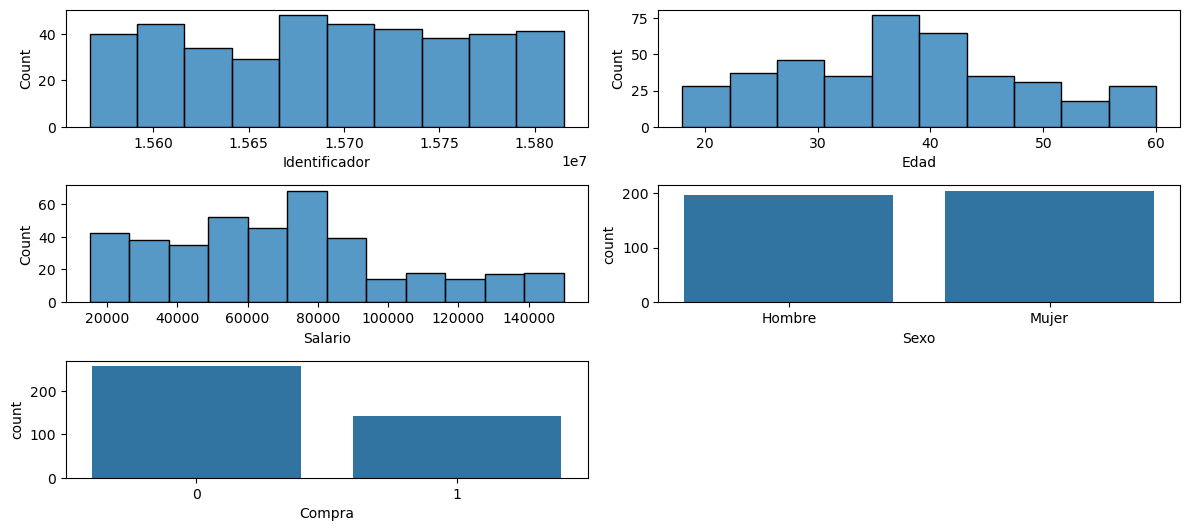

In [792]:
df_object = data_compras.select_dtypes(include=["object","category"]).columns.to_list()
df_num = data_compras.select_dtypes(include=[np.number]).columns.to_list()

df_num.remove("Compra")
df_object.extend(["Compra"])

plt.figure(figsize=(12,12))

subplot_index=1

for col in df_num:
    plt.subplot(7,2,subplot_index)
    sns.histplot(x=data_compras[col])
    subplot_index+=1

for col in df_object:
    plt.subplot(7,2,subplot_index)
    sns.countplot(x=data_compras[col])
    subplot_index+=1



plt.tight_layout()
plt.show()

#### DIVIDIR LOS DATOS EN CONJUNTO DE ENTRENAMIENTO Y PRUEBAS

In [793]:
data_compras_dropped=data_compras.drop("Identificador" , axis=1)
# Vamos a eliminar la columna identificador ya que tras comprobar que no tiene apenas relacion con la y
# y tampoco tiene sentido tenerlo.

X, y = data_compras_dropped.drop("Compra", axis = 1), data_compras_dropped["Compra"]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=42)

#### PREPARAR LOS DATOS
Algunas pistas a tener en cuenta (** esto no quiere decir que sólo haya que hacer esto**):
* No usar las características que no sirven
* Tratar los valores nulos (aunque ahora no haya)
* Edad: primeramente convertir en categórica poniendo las siguientes etiquetas y luego aplicar el cambio que procede en las variables categóricas (es para aplicar los diferentes tipos de transformaciones que hay, no porque tenga mucho sentido).
  * 0-20 --> Rango1
  * 20-30 --> Rango 2
  * 30-40 --> Rango 3
  * 40-50 --> Rango 4
  * 50- --> Rango 5

* Salario: aplicar logaritmo (aunque no tenga una cola larga a la derecha) y luego estandarizar

In [794]:
def encode_sex(X):
    X[:, 0] = np.where(X[:, 0] == 'Hombre', 0, 1) 
    return X

def categorize_age(df):
    df = pd.DataFrame(df, columns = ["Edad"])
    df["Edad"] = pd.cut(df["Edad"], bins = [0, 20, 30, 40, 50, np.inf], labels = ["Rango 1", "Rango 2", "Rango 3", "Rango 4", "Rango 5"])
    return df

def names_age(function_transformer, feature_names_in):
    return ["Edad"]

sex_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    FunctionTransformer(encode_sex, feature_names_out="one-to-one"))

age_pipeline = make_pipeline(
    SimpleImputer(), 
    FunctionTransformer(categorize_age, feature_names_out=names_age),
    OneHotEncoder(handle_unknown="ignore")
)

salary_pipeline = make_pipeline(
    SimpleImputer(strategy="mean"),
    FunctionTransformer(np.log,feature_names_out="one-to-one"),
    StandardScaler())


preprocessing = ColumnTransformer([
    ("sex_transform", sex_pipeline, ["Sexo"]),
    ("age_transform", age_pipeline, ["Edad"]),
    ("fare_transform", salary_pipeline, ["Salario"]),
] , verbose_feature_names_out= False)

df_transformed = preprocessing.fit_transform(data_compras_dropped)
print(df_transformed)
df_transformed.shape

[[0 1.0 0.0 ... 0.0 0.0 -2.0954143770551927]
 [0 0.0 0.0 ... 0.0 0.0 -2.002996029019135]
 [1 0.0 1.0 ... 0.0 0.0 -0.6238045715401285]
 ...
 [1 0.0 0.0 ... 1.0 0.0 -2.002996029019135]
 [0 0.0 0.0 ... 0.0 0.0 -1.100717760509505]
 [1 0.0 0.0 ... 1.0 0.0 -0.9439439011241707]]


(400, 7)

In [795]:
preprocessing.get_feature_names_out()

array(['Sexo', 'Edad_Rango 1', 'Edad_Rango 2', 'Edad_Rango 3',
       'Edad_Rango 4', 'Edad_Rango 5', 'Salario'], dtype=object)